# Section 1, Problem Statement, and Overview of Results

### First, we must import our libraries

In [22]:
import pandas as pd
from pandas.io.json import json_normalize #this is a crutial, and awesome library. if you work with json, you need this in your life
import numpy as np 
import matplotlib.pyplot as plt
import json, re, os
%matplotlib inline
plt.rcParams['figure.figsize'] = 15,15
from datetime import datetime, timedelta
from pprint import pprint

# These two modules are a collection of custom functions built to connect
# and gather information from unleashed software via it's api.
from ulConnect import getULData, convertDateToDate
from WatchDog import getAllSOH, getSOH


### Here we will just make some adjustments to the default way pandas displays dataframes. I like to be able to see all the columns

In [23]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

### Now we are going to define a function to extract the stock on hand from unleashed based on a particular date.

This will show us the quantities of everything we have for each day. From there we have the base of our analytics

In [24]:
def get_soh_as_of_date(date_string=None):
    r = getULData('StockOnHand/','pageSize=1000') # create a requests with the maximum size
    pages = r.json()['Pagination']['NumberOfPages'] # determine the number of pages that go with this request
    if not date_string: # we should define a default date string
        date_string = str(datetime.now().year)+'-'+str(datetime.now().month)+'-'+str(datetime.now().day)
    # Get a request list of Sales Orders by
    # looping through pages and get all POs
    soh = []
    for i in range(1,pages+1):
        # Make a request for the specific page we want
        r = getULData('StockOnHand/'+str(i), 'pageSize=1000&asAtDate='+date_string)
        # append the json objects in the object called "Items" to the list of stock on hand material
        for item in r.json()['Items']:
            if item not in soh:
                soh.append(item)
#     Write this object to a file for future great ideas
    if os.path.isfile('stockOnHand_'+date_string+'.json'):
        os.remove('stockOnHand_'+date_string+'.json')
    with open('stockOnHand_'+date_string+'.json', 'w') as outfile:
        json.dump(soh, outfile)
#  Also return the soh list of json objects.
    return(soh)

## Show that all the files of stock on hand have been previously downloaded.

Here you can see, I have already downloaded the stock on hand from the beginning of 2019 to recently

In [25]:
! ls | grep stockOnHand_

stockOnHand_2019-2-28.json
stockOnHand_2019-9-13.json


### Similar to getting the stock on hand, we are going to grab all the products in our product catalogue. 

This will be handy when we are trying to compare what has happened to our inventory values of stocking vs non-stocking products.

I am going to cheat here and just copy in the function, it is very similar to the stock on hand function above.

In [26]:
def get_all_products():
    r = getULData('Products/','pageSize=1000')
    pages = r.json()['Pagination']['NumberOfPages']
    # Get a request list of products by
    # looping through pages and get all listed products
    products = []
    for i in range(1,pages+1):
        # print(i)
        r = getULData('Products/'+str(i), 'pageSize=1000')
        for item in r.json()['Items']:
            if item not in products:
                products.append(item)
    if os.path.isfile('products.json'):
        os.remove('products.json')
    with open('products.json', 'w') as outfile:
        json.dump(products, outfile)

    return(products)

# Grab the initial inventory at the beginning of the project (feb, 28(ish), 2019)

Here we want to compare the inventory values broken up into product groups at the beginning of this project to the most recent inventory values.

In [27]:
initial_stock_df = pd.read_json('stockOnHand_2019-2-28.json')

# Download the inventory values of today:

In [28]:
_ = get_soh_as_of_date(date_string='%s-%s-%s' % (datetime.now().year, datetime.now().month, datetime.now().day))

In [40]:
current_inventory_df = pd.read_json('stockOnHand_%s-%s-%s.json'% (datetime.now().year, datetime.now().month, datetime.now().day))

# Examine the resulting dataframe:

In [41]:
current_inventory_df.head()

,AllocatedQty,AvailableQty,AvgCost,DaysSinceLastSale,Guid,LastModifiedOn,OnPurchase,ProductCode,ProductDescription,ProductGroupName,ProductGuid,ProductSourceId,QtyOnHand,TotalCost,Warehouse,WarehouseCode,WarehouseId
0,0.0,2.0,3.380000,54.0,594091f0-c613-42ff-9433-49337bf7be32,/Date(1564057822394)/,0.0,10' Pad6314,Padco Refill Lambskin 10',Applicators,594091f0-c613-42ff-9433-49337bf7be32,NaN,2.0,6.760,,,
1,0.0,9.0,3.840000,64.0,5d6c26aa-f64d-4237-94a8-598449b2a2c0,/Date(1563218821284)/,0.0,12' Pad6316,Padco Refill Lambskin 12',Applicators,5d6c26aa-f64d-4237-94a8-598449b2a2c0,NaN,9.0,34.560,,,
2,1.0,12.0,5.250000,292.0,61b7111f-4eb3-469c-a946-14938398b151,/Date(1544736064492)/,0.0,16' Pad6320,Padco Refill Lambskin 16',Applicators,61b7111f-4eb3-469c-a946-14938398b151,NaN,13.0,68.250,,,
3,0.0,140.0,5.590000,40.0,b0ad60e3-4322-439f-9bfb-0d5a6f0785a5,/Date(1565290579484)/,0.0,3MBelReg729100,7-7/8'x29-1/2' 100 Grit Regalite belt,Sandpaper,b0ad60e3-4322-439f-9bfb-0d5a6f0785a5,NaN,140.0,782.600,,,
4,0.0,30.0,5.832833,67.0,56f3791c-55a8-464e-bac5-17b005d71a96,/Date(1562946750077)/,0.0,3mBelReg729120,7-7/8'x29-1/2' 120 Grit Regalite belt,Sandpaper,56f3791c-55a8-464e-bac5-17b005d71a96,NaN,30.0,174.985,,,


# Calculate the initial inventory totals seperated by product group, and summed:

The way we will compare the effect on the total inventory value from here on will be by comparing the value of the product groups we hvae them seperated into.

In [42]:
initial_total_values_df = initial_stock_df[['ProductGroupName', 'TotalCost']].groupby('ProductGroupName').sum()
current_total_values_df = current_inventory_df[['ProductGroupName', 'TotalCost']].groupby('ProductGroupName').sum()

# Concatinate these two df's so we can compare them better

In [43]:
change_df = pd.concat([initial_total_values_df,current_total_values_df], axis=1)
change_df.columns = ['Initial', 'Final']

/Users/jon/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


# Take a peak:

In [44]:
change_df.head(20)

,Initial,Final
,8595.823,13227.930
Adhesives,2601.734,6778.621
American Cherry Trim,NaN,2259.450
Applicators,4673.072,3555.865
Ash Trim,NaN,1148.229
BC Trim,NaN,1041.694
Birch Trim,NaN,0.000
Fasteners,14225.160,14203.653
Filler,4839.136,3601.530
Finish,133837.440,85898.499


# Plot these graphs 

Comparing data in tables is not nearly as effective as having a look at a plot of the same information

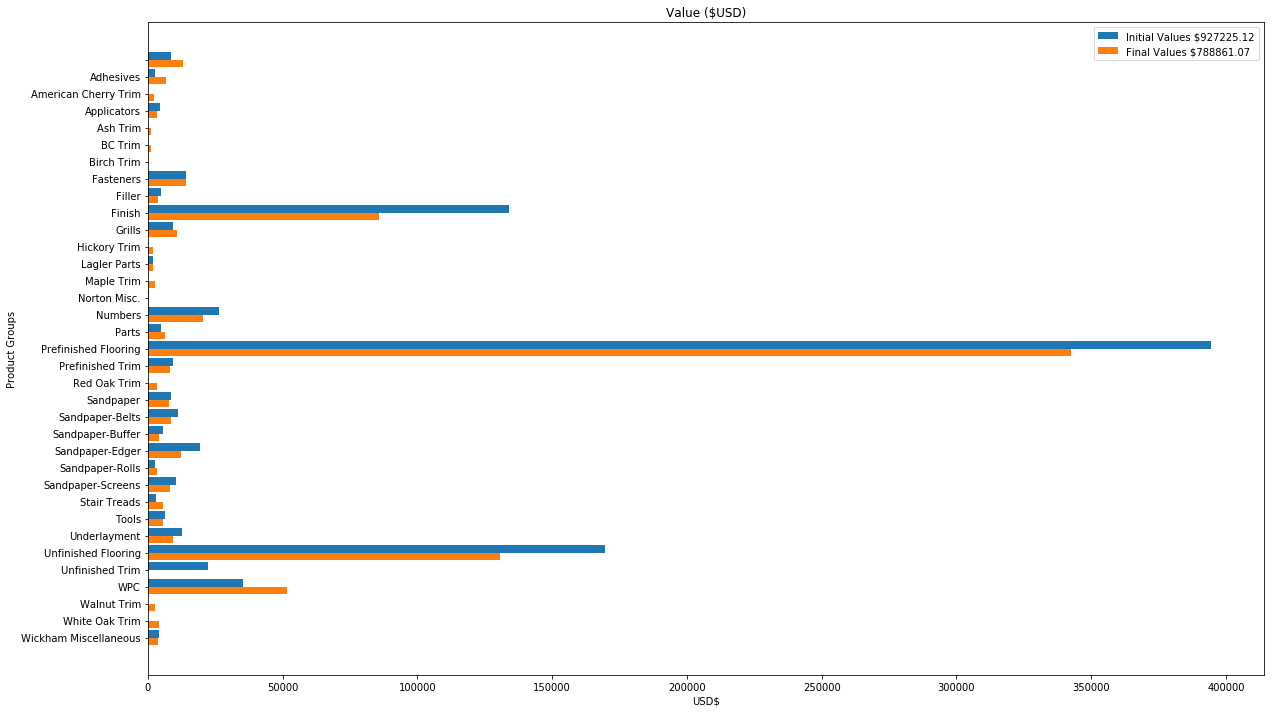

In [45]:
labels = change_df.index
initial_values = change_df.Initial
final_values= change_df.Final

x = np.arange(len(labels))  # the label locations
width = 0.45  # the width of the bars

fig, ax = plt.subplots(figsize=(20,12))
rects1 = ax.barh(x - width/2, initial_values, width, label='Initial Values $' + str(np.round(change_df.Initial.sum(),2)))
rects2 = ax.barh(x + width/2, final_values, width, label='Final Values $' + str(np.round(change_df.Final.sum(),2)))

pgs = current_total_values_df.index
y_pos = np.arange(len(pgs))

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Product Groups')
ax.set_title('Value ($USD)')
ax.set_yticks(y_pos)
ax.set_yticklabels(pgs)
ax.invert_yaxis()
ax.set_xlabel('USD$')
ax.legend()

plt.show()

# Section 2, Walkthrough of the System

# Now we are going to discuss the process by which we lowered these values, and analyze the effect this system has on the overall inventory we carry.

### First, we suspect that our big customers are ordering product long before they acutally need it, and we are sitting on that materail for a long time, contributing to increased levels of inventory that are typically non-stock:

#### Lets look at three customers in particular:

In [46]:
r = getULData('SalesOrders/','pageSize=1000&customerId=11f96960-a3e3-4f3d-9883-b707274afef0&startDate=2018-4-9&endDate=2019-3-1&orderStatus=Completed')
so_df = pd.read_json(json.dumps(r.json()['Items']))
so_df.OrderDate = so_df.OrderDate.apply(convertDateToDate)
so_df.CompletedDate = so_df.CompletedDate.apply(convertDateToDate)
so_df['Time_To_Complete'] = so_df.CompletedDate - so_df.OrderDate
so_df[so_df.Time_To_Complete > timedelta(0)]['Time_To_Complete'].mean()

Timedelta('77 days 18:50:04.203428')

In [47]:
r = getULData('SalesOrders/','pageSize=1000&customerId=2c0d01c7-c492-4385-987b-8ad8cdd34416&startDate=2018-4-9&endDate=2019-3-1&orderStatus=Completed')
so_df = pd.read_json(json.dumps(r.json()['Items']))
so_df.OrderDate = so_df.OrderDate.apply(convertDateToDate)
so_df.CompletedDate = so_df.CompletedDate.apply(convertDateToDate)
so_df['Time_To_Complete'] = so_df.CompletedDate - so_df.OrderDate
so_df[so_df.Time_To_Complete > timedelta(0)]['Time_To_Complete'].mean()

Timedelta('62 days 18:58:10.259015')

In [48]:
r = getULData('SalesOrders/','pageSize=1000&customerId=f31ae7bd-b182-474e-b429-c91a07b2b567&startDate=2018-4-9&endDate=2018-12-31&orderStatus=Completed')
so_df = pd.read_json(json.dumps(r.json()['Items']))
so_df.OrderDate = so_df.OrderDate.apply(convertDateToDate)
so_df.CompletedDate = so_df.CompletedDate.apply(convertDateToDate)
so_df['Time_To_Complete'] = so_df.CompletedDate - so_df.OrderDate
so_df[so_df.Time_To_Complete > timedelta(0)]['Time_To_Complete'].mean()

Timedelta('29 days 14:12:03.853100')

In [49]:
r = getULData('SalesOrders/','pageSize=1000&customerId=51448e4e-3470-42fd-a9a9-5dde118e4efb&startDate=2018-4-9&endDate=2019-3-1&orderStatus=Completed')
so_df = pd.read_json(json.dumps(r.json()['Items']))
so_df.OrderDate = so_df.OrderDate.apply(convertDateToDate)
so_df.CompletedDate = so_df.CompletedDate.apply(convertDateToDate)
so_df['Time_To_Complete'] = so_df.CompletedDate - so_df.OrderDate
so_df[so_df.Time_To_Complete > timedelta(0)]['Time_To_Complete'].mean()

Timedelta('35 days 23:49:10.124900')

### So for decent sized customers (you'll have to trust me on that) we're seeing time between order and delivery of 26 to 77 days.

### Let's compare that to the average time to get material delivered from our largest flooring suppliers:

In [51]:
po_df = pd.read_json('purchaseOrders.json')
po_df.CreatedOn = po_df.CreatedOn.apply(convertDateToDate)
po_df.CompletedDate.dropna(inplace=True)
po_df.CompletedDate = po_df.CompletedDate.apply(convertDateToDate)

po_df.head()

,BCSubTotal,BCTaxTotal,BCTotal,Comments,CompletedDate,CreatedBy,CreatedOn,Currency,DeliveryCity,DeliveryCountry,DeliveryName,DeliveryPostCode,DeliveryRegion,DeliveryStreetAddress,DeliveryStreetAddress2,DeliverySuburb,DiscountRate,ExchangeRate,Guid,LastModifiedBy,LastModifiedOn,OrderDate,OrderNumber,OrderStatus,Printed,PurchaseOrderLines,ReceivedDate,RequiredDate,SalesOrders,SubTotal,Supplier,SupplierInvoiceDate,SupplierRef,Tax,TaxRate,TaxTotal,Total,TotalVolume,TotalWeight,Warehouse,XeroTaxCode
0,8006.86,0,8006.86,None,2018-04-09 19:11:28.862,jon@iwhardwood.com,2018-04-08 13:34:18.314,"{'CurrencyCode': 'USD', 'Description': 'United...",Rochester,None,"Installers Warehouse, Inc.",14606.0,NY,1677C Lyell Ave.,None,None,0,1,61a227f7-fc66-423f-b0ea-4d5e6fd9c8dc,sue@iwhardwood.com,/Date(1523301194643)/,/Date(1523160000000)/,PO-00000002,Complete,NaN,[{'Guid': '8b33d1c3-6376-49b9-b64a-78b4b6899c0...,/Date(1523300480970)/,/Date(1523160000000)/,[],8006.86,{'Guid': 'd320ea27-5022-44fe-b03a-7038f3e85d65...,/Date(1523246400000)/,S3319,"{'TaxCode': 'NONE', 'Description': None, 'TaxR...",0,0,8006.86,0,0,"{'WarehouseCode': 'IW', 'WarehouseName': 'Inst...",NONE
1,440.00,0,440.00,None,2018-04-09 19:06:01.377,jon@iwhardwood.com,2018-04-08 13:35:52.611,"{'CurrencyCode': 'USD', 'Description': 'United...",Rochester,None,"Installers Warehouse, Inc.",14606.0,NY,1677C Lyell Ave.,None,None,0,1,0e78b102-4733-4e1f-bcb7-1158c260b666,sue@iwhardwood.com,/Date(1523300761377)/,/Date(1523160000000)/,PO-00000003,Complete,NaN,[{'Guid': '3ea483b9-93bb-4072-ab64-bedad89f3f7...,/Date(1523300759861)/,/Date(1523160000000)/,[],440.00,{'Guid': 'd320ea27-5022-44fe-b03a-7038f3e85d65...,/Date(1522900800000)/,S3319,"{'TaxCode': 'NONE', 'Description': None, 'TaxR...",0,0,440.00,0,0,"{'WarehouseCode': 'IW', 'WarehouseName': 'Inst...",NONE
2,1428.48,0,1428.48,None,2018-04-23 21:00:11.599,sue@iwhardwood.com,2018-04-08 13:46:06.639,"{'CurrencyCode': 'USD', 'Description': 'United...",Rochester,None,"Installers Warehouse, Inc.",14606.0,NY,1677C Lyell Ave.,None,None,0,1,6765560e-f7b2-4024-b15c-b031c80d3d9c,sue@iwhardwood.com,/Date(1524517211599)/,/Date(1523160000000)/,PO-00000004,Complete,NaN,[{'Guid': '08a73e96-dc69-4f08-bba5-78beb319e20...,/Date(1524517210365)/,/Date(1523160000000)/,[{'Guid': 'd3e0b4f7-0db9-4030-b7bc-702b8897adf...,1428.48,{'Guid': '997d9738-72e7-4d21-a648-32d763dd990e...,/Date(1523419200000)/,189124,"{'TaxCode': 'NONE', 'Description': None, 'TaxR...",0,0,1428.48,0,0,"{'WarehouseCode': 'IW', 'WarehouseName': 'Inst...",NONE
3,432.00,0,432.00,None,2018-05-14 14:29:20.108,jon@iwhardwood.com,2018-04-08 13:49:57.109,"{'CurrencyCode': 'USD', 'Description': 'United...",Rochester,None,"Installers Warehouse, Inc.",14606.0,NY,1677C Lyell Ave.,None,None,0,1,abdd264f-ae10-4359-8609-4d5e1210c9d1,sue@iwhardwood.com,/Date(1526308160108)/,/Date(1523160000000)/,PO-00000005,Complete,NaN,[{'Guid': '3ebd5f4f-cf12-4b76-a276-19b155db764...,/Date(1526308158958)/,/Date(1526270400000)/,[],432.00,{'Guid': 'd320ea27-5022-44fe-b03a-7038f3e85d65...,/Date(1526011200000)/,S3421,"{'TaxCode': 'NONE', 'Description': None, 'TaxR...",0,0,432.00,0,0,"{'WarehouseCode': 'IW', 'WarehouseName': 'Inst...",NONE
4,2201.92,0,2201.92,None,2018-04-25 15:33:59.356,jon@iwhardwood.com,2018-04-08 13:59:12.391,"{'CurrencyCode': 'USD', 'Description': 'United...",Rochester,None,"Installers Warehouse, Inc.",14606.0,NY,1677C Lyell Ave.,None,None,0,1,4df6d86d-8c8a-4e2d-8d5c-f993a7865107,sue@iwhardwood.com,/Date(1524670439356)/,/Date(1523160000000)/,PO-00000008,Complete,NaN,[{'Guid': '731d4098-e7d1-45ee-9a9d-bf11703eb07...,/Date(1524670437090)/,/Date(1524628800000)/,[],2201.92,{'Guid': '0871166d-a9b7-439c-afdf-3f67c82ba5c4...,/Date(1523937600000)/,41781,"{'TaxCode': 'NONE', 'Description': None, 'TaxR...",0,0,2201.92,0,0,"{'WarehouseCode': 'IW', 'WarehouseName': 'Inst...",NONE


### Do a little cleaning

In [52]:
po_df = po_df[~po_df.CompletedDate.isna()]
po_df['Time_To_Complete'] = po_df.CompletedDate - po_df.CreatedOn
po_df = po_df[['Supplier', 'CreatedOn', 'CompletedDate', 'Time_To_Complete', 'Total']]
po_df.head()

,Supplier,CreatedOn,CompletedDate,Time_To_Complete,Total
0,{'Guid': 'd320ea27-5022-44fe-b03a-7038f3e85d65...,2018-04-08 13:34:18.314,2018-04-09 19:11:28.862,1 days 05:37:10.548000,8006.86
1,{'Guid': 'd320ea27-5022-44fe-b03a-7038f3e85d65...,2018-04-08 13:35:52.611,2018-04-09 19:06:01.377,1 days 05:30:08.766000,440.00
2,{'Guid': '997d9738-72e7-4d21-a648-32d763dd990e...,2018-04-08 13:46:06.639,2018-04-23 21:00:11.599,15 days 07:14:04.960000,1428.48
3,{'Guid': 'd320ea27-5022-44fe-b03a-7038f3e85d65...,2018-04-08 13:49:57.109,2018-05-14 14:29:20.108,36 days 00:39:22.999000,432.00
4,{'Guid': '0871166d-a9b7-439c-afdf-3f67c82ba5c4...,2018-04-08 13:59:12.391,2018-04-25 15:33:59.356,17 days 01:34:46.965000,2201.92


### The supplier field is a nested json object, we will extract that using json_normalize

In [53]:
po_df = pd.concat([po_df, json_normalize(po_df.Supplier)], axis=1)
po_df.SupplierCode.dropna(inplace=True)

### Here we will have a look at our three largest manufacturers of prefinished wood flooring to see what the average time and standard deviation is between when we place an order, and when we receive the material in our warehouse.

In [54]:
print(po_df[po_df.SupplierName == 'WICKHAM HARDWOOD FLOORING']['Time_To_Complete'].mean(), '\n',
po_df[po_df.SupplierName == 'REAL WOOD FLOORS']['Time_To_Complete'].mean(),'\n',
po_df[po_df.SupplierName == 'American OEM']['Time_To_Complete'].mean())
print(po_df[po_df.SupplierName == 'WICKHAM HARDWOOD FLOORING']['Time_To_Complete'].std(), '\n',
po_df[po_df.SupplierName == 'REAL WOOD FLOORS']['Time_To_Complete'].std(),'\n',
po_df[po_df.SupplierName == 'American OEM']['Time_To_Complete'].std())

16 days 10:03:20.624115 
 12 days 19:21:45.422590 
 24 days 19:33:15.323666
10 days 20:16:54.973582 
 14 days 20:23:12.943657 
 19 days 18:25:34.988004


### Here we see that in most cases the time it takes to receive a floor from the manufacturer is considerably less than the time between when we receive the customer's order, and when they need it.

### Now we build a system that will allow us to reduce the time period we are holding onto material for a customer

#### Step 1) Understand the status flag for sales orders: 

A sales order can be in either "Parked", "Placed", or "Backoredered" status. We use each of these states for something very specific:

A Placed order is in stock, and ready to be delivered any time
A Backordered order is one where some, or all, of the materail on the sales order has to be ordered from the manufacturer, is currently on a Purchase order, and is being made at the manufacturing facility.
A Parked order is one where we will need to order some materail to fufil the order, but we have not placed that PO yet.

#### Step 2) Using that informaiton:

Our system will look for all Parked sales orders every day, calculate the mean time to fufill an order from the corresponding manufacturer, plus one standard deviation on that time, and make a determination on whether that order should be moved from Parked status to Backordered status, and subsequently purchased from the manufacturer

The system makes this determination by checking if the time delta between the customer's required delivery date, and the current day is less than or equal to the mean time to receive an order + one standard deviation.

If this is the case, an email is triggered letting the inside sales team know to place the order.

## Get all sales orders in parked status:

In [55]:
r = getULData('SalesOrders/', 'pageSize=1000&orderStatus=Parked')
sales_orders_df = pd.read_json(json.dumps(r.json()['Items']))
sales_orders_df[['CreatedOn', 'RequiredDate']].head()

,CreatedOn,RequiredDate
0,/Date(1568660541667)/,/Date(1568674800000)/
1,/Date(1568640506450)/,/Date(1568674800000)/
2,/Date(1568402615799)/,/Date(1568415600000)/
3,/Date(1568320361448)/,/Date(1568329200000)/
4,/Date(1568123404512)/,/Date(1568156400000)/


## The dates in unleashed come through as a datestamp, so my connection program to unleashed has the function convertDateToDate()

In [56]:
sales_orders_df.CreatedOn = sales_orders_df.CreatedOn.apply(convertDateToDate)
sales_orders_df.RequiredDate = sales_orders_df.RequiredDate.apply(convertDateToDate)
sales_orders_df[['CreatedOn', 'RequiredDate']].head()

,CreatedOn,RequiredDate
0,2019-09-16 19:02:21.667,2019-09-16 23:00:00
1,2019-09-16 13:28:26.450,2019-09-16 23:00:00
2,2019-09-13 19:23:35.799,2019-09-13 23:00:00
3,2019-09-12 20:32:41.448,2019-09-12 23:00:00
4,2019-09-10 13:50:04.512,2019-09-10 23:00:00


#### This is all fine, however, in the sales orders dataframe we can't see the actual items customers want to order
We must extract the nested json object labeled SalesOrderLines

Let's have a look here:

In [57]:
sales_orders_df.SalesOrderLines[1]

[{'LineNumber': 1,
  'LineType': None,
  'Product': {'Guid': '2bb88b37-a4fe-4542-a8c3-1e0681c74cf9',
   'ProductCode': 'LLNumWhiRQ2',
   'ProductDescription': "5/16 X 2' W/O R&Q Numbers S&B"},
  'DueDate': '/Date(1568640506420)/',
  'OrderQuantity': 125.0,
  'UnitPrice': 5.09,
  'DiscountRate': 0.0,
  'LineTotal': 636.25,
  'Volume': None,
  'Weight': None,
  'Comments': None,
  'AverageLandedPriceAtTimeOfSale': 2.85,
  'TaxRate': 0.08,
  'LineTax': 50.9,
  'XeroTaxCode': 'Monroe County',
  'BCUnitPrice': 5.09,
  'BCLineTotal': 636.25,
  'BCLineTax': 50.9,
  'LineTaxCode': None,
  'XeroSalesAccount': 'Sales',
  'SerialNumbers': None,
  'BatchNumbers': None,
  'Guid': '2a486b95-6743-4bea-934e-83150aa40ca1',
  'LastModifiedOn': '/Date(1568641765005)/'}]

I found a cool description of how to use json_normalize on the kaggle website here: https://www.kaggle.com/jboysen/quick-tutorial-flatten-nested-json-in-pandas

I hope that helps someone else to understand this utility.

In [58]:
sales_order_lines_df = json_normalize(r.json()['Items'],record_path='SalesOrderLines', meta=['OrderNumber', 'RequiredDate', 'CreatedOn'])
parked_products = json_normalize(sales_order_lines_df.Product)
sales_order_lines_df['ProductCode'] = parked_products.ProductCode

### Readjust dates

In [59]:
sales_order_lines_df.CreatedOn = sales_order_lines_df.CreatedOn.apply(convertDateToDate)
sales_order_lines_df.RequiredDate = sales_order_lines_df.RequiredDate.apply(convertDateToDate)

### Have a look at the columns to see what data is necessary for working with

In [60]:
sales_order_lines_df.columns

Index(['AverageLandedPriceAtTimeOfSale', 'BCLineTax', 'BCLineTotal', 'BCUnitPrice', 'BatchNumbers', 'Comments', 'DiscountRate', 'DueDate', 'Guid', 'LastModifiedOn', 'LineNumber', 'LineTax', 'LineTaxCode', 'LineTotal', 'LineType', 'OrderQuantity', 'Product', 'SerialNumbers', 'TaxRate', 'UnitPrice', 'Volume', 'Weight', 'XeroSalesAccount', 'XeroTaxCode', 'OrderNumber', 'RequiredDate', 'CreatedOn', 'ProductCode'], dtype='object')

In [61]:
sales_order_lines_df.head()

,AverageLandedPriceAtTimeOfSale,BCLineTax,BCLineTotal,BCUnitPrice,BatchNumbers,Comments,DiscountRate,DueDate,Guid,LastModifiedOn,LineNumber,LineTax,LineTaxCode,LineTotal,LineType,OrderQuantity,Product,SerialNumbers,TaxRate,UnitPrice,Volume,Weight,XeroSalesAccount,XeroTaxCode,OrderNumber,RequiredDate,CreatedOn,ProductCode
0,7.618999,3.45,43.16,5.395,None,,0.5,/Date(1568660541403)/,05bb7213-6622-46fc-8ada-085b194a4643,/Date(1568663337381)/,1,3.45,None,43.16,None,8.0,{'Guid': '6528df45-b307-4b10-a99d-1a82662daa85...,None,0.08,10.79,None,None,Sales,Monroe County,SO-00006151,2019-09-16 23:00:00,2019-09-16 19:02:21.667,PolPriSat
1,6.631007,3.00,37.56,4.695,None,,0.5,/Date(1568660541403)/,896c5f42-a8ff-4b54-9446-1d2fc1d6a5be,/Date(1568663337381)/,2,3.00,None,37.56,None,8.0,{'Guid': '95e5fec0-8b3d-49d2-b4fc-98897b064ae3...,None,0.08,9.39,None,None,Sales,Monroe County,SO-00006151,2019-09-16 23:00:00,2019-09-16 19:02:21.667,PolFasSea
2,2.850000,50.90,636.25,5.090,None,None,0.0,/Date(1568640506420)/,2a486b95-6743-4bea-934e-83150aa40ca1,/Date(1568641765005)/,1,50.90,None,636.25,None,125.0,{'Guid': '2bb88b37-a4fe-4542-a8c3-1e0681c74cf9...,None,0.08,5.09,None,None,Sales,Monroe County,SO-00006140,2019-09-16 23:00:00,2019-09-16 13:28:26.450,LLNumWhiRQ2
3,0.000000,0.00,0.00,0.000,None,,0.0,/Date(1568402615766)/,e455ab96-6c86-4013-81dc-887ed341d3d6,/Date(1568403024617)/,1,0.00,None,0.00,None,26.5,{'Guid': '2f5673c3-252b-4a80-81ca-071b482e4277...,None,0.00,0.00,None,None,Sales,NONE,SO-00006134,2019-09-13 23:00:00,2019-09-13 19:23:35.799,FroSon8HicWBGre
4,0.000000,0.00,0.00,0.000,None,,0.0,/Date(1568402615766)/,56177dcd-8d44-4d69-8762-1f054b12a1d0,/Date(1568403024622)/,2,0.00,None,0.00,None,53.0,{'Guid': '9f6b15a3-ff02-4021-a271-3d2009112d22...,None,0.00,0.00,None,None,Sales,NONE,SO-00006134,2019-09-13 23:00:00,2019-09-13 19:23:35.799,FroSon8WOWBBut


#### Now we have a dataframe that displays all the orders that could potentially need to be ordered from their respective manufacturers.

From here, we must check our exisiting inventory to determine which of the sales order lines we might need to purchase.

In [63]:
stock_on_hand_df = current_inventory_df.copy() #pd.read_json('stockOnHand_IW.json')

### Now that we know what stock is available right now, we can check our sales order lines against that stock and see if we need to order anything:

This is where the fun is!

In [64]:
so_to_order = []
# iterate over the sales_order_lines_df for products
for idx, row in sales_order_lines_df.iterrows():
#     Determine jsut the soh pertaining to a single product code
    temp = stock_on_hand_df[stock_on_hand_df['ProductCode'] == row['ProductCode']]
#     We need to exclude the delivery code, and make sure there is a value returned by the SOH df
    if row['ProductCode'] != 'Delivery' and len(temp) > 0:

#          Make a little detour to get the supplier information on this product
        r = getULData('Products', 'productCode='+row['ProductCode'])
        p = json_normalize(r.json()['Items'])
#         Here we actually grab the supplier's name.
        sup_name = p['Supplier.SupplierName'].values[0]
#         use that supplier name to determine the average and std time to complete a po from that supplier
        mean_time_to_complete = po_df[po_df['SupplierName'] == sup_name]['Time_To_Complete'].mean()
        std_time_to_complete = po_df[po_df['SupplierName'] == sup_name]['Time_To_Complete'].std()
        
        #determine if that time is greater or equal to the time from now until when the customer needs the product
        # and if so, append the order to the list of orders to order :-P
        need_by_delta = row['RequiredDate'] - datetime.today()
        po_receive_delta = mean_time_to_complete + std_time_to_complete

#       AvailableQty can be negative or positive, onPurchase is only ever >=0
        val = (temp['AvailableQty'].values[0] + temp['OnPurchase'].values[0])
        if val < 0 and (need_by_delta <= po_receive_delta):
#           Finally, append all the data the inside sales team is going to need in order to order the correct product and quantities.
            so_to_order.append([row['OrderNumber'], row['ProductCode'], row['OrderQuantity'], row['RequiredDate']])



### Now we have the list of sales orders we know should be sent to their respective manufacturers.
The next step is to email this list to our inside sales team, and let them know to place the purchase orders

In [65]:
so_to_order = pd.DataFrame(so_to_order, columns=['Order Number', 'Product', 'Amount Needed','Required Date'])
so_to_order.head()

,Order Number,Product,Amount Needed,Required Date
0,SO-00006134,FroSon8HicWBGre,26.5,2019-09-13 23:00:00
1,SO-00006134,FroSon8WOWBBut,53.0,2019-09-13 23:00:00
2,SO-00006134,FroSon8WOWBMel,26.5,2019-09-13 23:00:00


In [66]:
import yagmail

### Build the email

In [67]:
html = '<!DOCTYPE html><html><body><h1>Sales orders that should be submitted as POs today:</h1><p></p></body></html>'
jon = 'jon@iwhardwood.com'
yag = yagmail.SMTP(user='jon@iwhardwood.com', password='SOME_PASSWORD_WOULD_GO_HERE')
yag.send(to=jon,subject='Test', contents=[html] )

SMTPAuthenticationError: (535, b'5.7.8 Username and Password not accepted. Learn more at\n5.7.8  https://support.google.com/mail/?p=BadCredentials d55sm1453572qta.41 - gsmtp')

# Section 3, Evaluation:

## Now that we have seen how the mechanics of the system work, what can be said about it's efficacy?

#### First we will look at inventory values of stock products and inventory values of nonstock products against the whole inventory landscape.

In [68]:
total_diff_df = pd.read_csv('product_values_by_product_group_daily.csv', index_col=0)
total_diff_df.index = pd.to_datetime(total_diff_df.index)
total_diff_df['Total'] = total_diff_df.sum(axis=1)
# total_diff_df.head()

In [69]:
stock_diff_df = pd.read_csv('Stocking_product_values_by_product_group_daily.csv',index_col=0)
stock_diff_df.index = pd.to_datetime(stock_diff_df.index)
stock_diff_df['Total'] = stock_diff_df.sum(axis=1)
# stock_diff_df.head()

### Plot only the prefinished flooring data

In [70]:
# Define our working date range
dates = pd.date_range('1/1/2019','8/3/2019') 

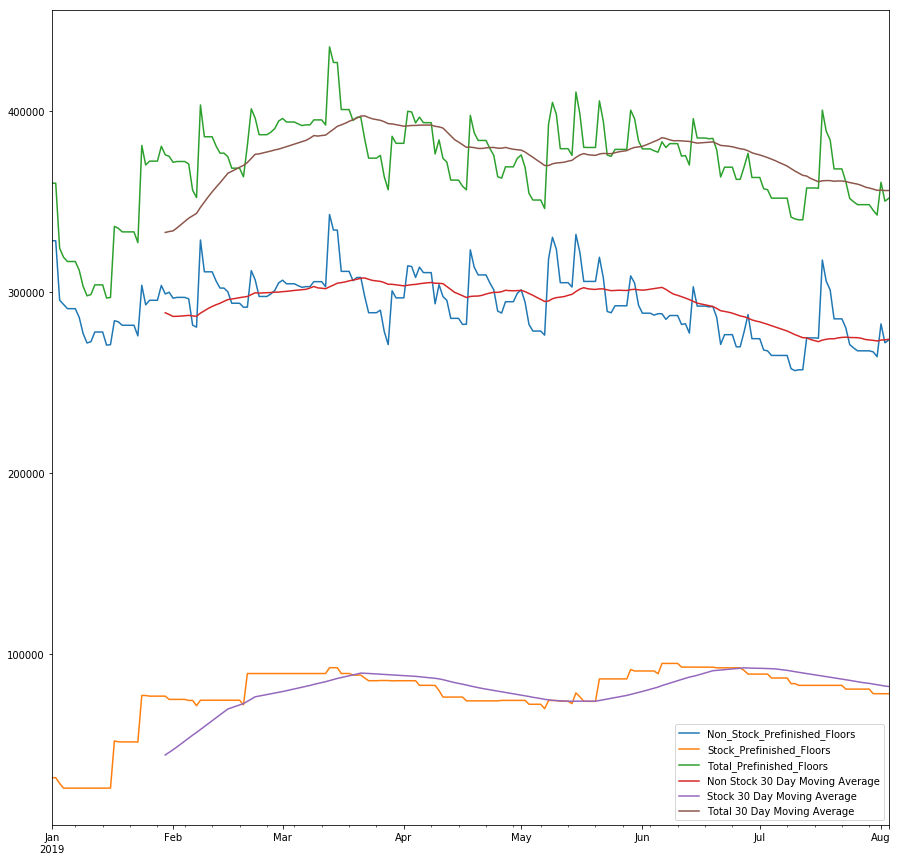

In [71]:
plotting_df = pd.DataFrame(index=dates)
plotting_df['Non_Stock_Prefinished_Floors'] = total_diff_df['Prefinished Flooring'] - stock_diff_df['Prefinished Flooring']
plotting_df['Stock_Prefinished_Floors'] = stock_diff_df['Prefinished Flooring']
plotting_df['Total_Prefinished_Floors'] = total_diff_df['Prefinished Flooring']
t_df = plotting_df.rolling(30).mean()
t_df.columns = ['Non Stock 30 Day Moving Average', 'Stock 30 Day Moving Average', 'Total 30 Day Moving Average']
plotting_df = pd.concat([plotting_df,t_df], axis=1)
plotting_df.plot()

### Plot the same analysis for all categories of inventory

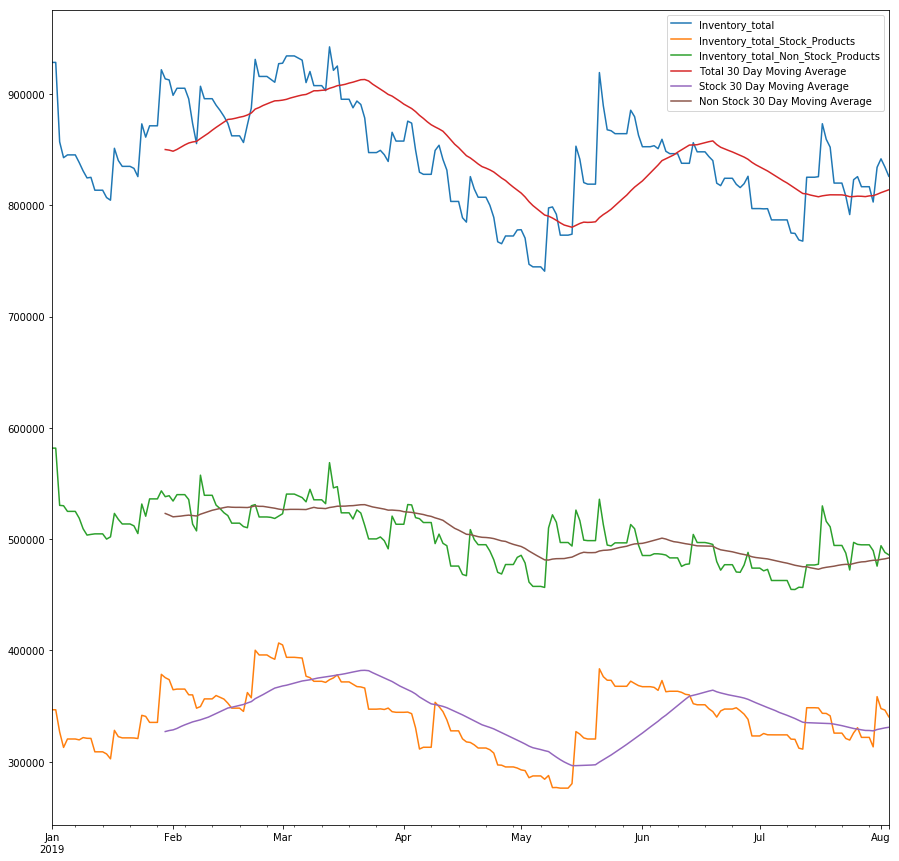

In [72]:
total_stock_plotting_df = pd.DataFrame(index=dates)
total_stock_plotting_df['Inventory_total'] = total_diff_df.Total
total_stock_plotting_df['Inventory_total_Stock_Products'] = stock_diff_df.Total
total_stock_plotting_df['Inventory_total_Non_Stock_Products'] = total_diff_df.Total - stock_diff_df.Total
t_df = total_stock_plotting_df.rolling(30).mean()
t_df.columns = ['Total 30 Day Moving Average', 'Stock 30 Day Moving Average', 'Non Stock 30 Day Moving Average']
total_stock_plotting_df = pd.concat([total_stock_plotting_df,t_df], axis=1)
total_stock_plotting_df.plot()

## Calculating average days to sell.

The average time it takes to sell a single product after it has been purchased and received is a standard KPI for businesses. We will analyze the performace of this approach to reducing inventory by calculating the average time it takes to sell an item, and plotting that against time.

### Average days to sell is calculated as:

### ads_t = time_delta / Inventory Turns
### inventory_turns = Cost of goods sold (for a time delta) / Average Inventory Value
### Cost of Goods Sold = initial inventory + value of purchases - final inventory 
    This is the value to the business of material that was shipped out up to a given day
### Average inventory = (initial_inv + final_inv)/2

So we will have to calculate these three properties

### First we get all the purchase orders that have been received, sorted by day. 
I have taken the liberty of doing all that work off screen for brevity

In [73]:
po_df = pd.read_csv('Purchase_Orders_Flattened.csv')
po_df['CreatedOn'] = pd.to_datetime(po_df.CreatedOn)
po_df['CompletedDate'] = pd.to_datetime(po_df.CompletedDate)
po_df.CreatedOn = pd.DatetimeIndex(po_df.CreatedOn).normalize()
po_df.CompletedDate = pd.DatetimeIndex(po_df.CompletedDate).normalize()

### Now that we have a dataframe of all purchase orders, we need the total amount of material received into the warehouse every day. 

In [74]:
daily_purchases_df = po_df.groupby('CompletedDate').sum()
daily_purchases_df.columns=['DatePurchaseTotal']
daily_purchases_df[datetime(2019,1,1):]

,DatePurchaseTotal
CompletedDate,
2019-01-02,6020.88
2019-01-03,40.00
2019-01-04,10596.74
2019-01-07,4848.10
2019-01-08,4617.92
2019-01-10,579.22
2019-01-11,9936.74
2019-01-14,659.22
2019-01-15,2313.23


### Now let's merge this df with the dataframe of all stock on hand broken down by product group, merging on the date:

In [75]:
daily_inv_val_with_purchases_df = pd.merge(total_diff_df, daily_purchases_df, how='left',left_index=True, right_index=True)

### Not every day is a day where we have material being received into the warehouse, so there are some NA values to fill in this new dataframe

In [76]:
daily_inv_val_with_purchases_df.DatePurchaseTotal=daily_inv_val_with_purchases_df.DatePurchaseTotal.fillna(value=0.0)

### Calculate the average inventory value since the beginning of the year

In [77]:
daily_inv_val_with_purchases_df['AverageInventory'] = (daily_inv_val_with_purchases_df.Total + daily_inv_val_with_purchases_df.iloc[0]['Total']) / 2.0

### We'll use tomorrow's inventory value as our "final inventory value" for the calculation of cogs

In [78]:
p = daily_inv_val_with_purchases_df.Total.values

In [79]:
len(p)

215

In [80]:
# Remove the first value, and append a zero value to the end of the array
np.delete(p, 0)
np.append(p,np.array([0]))
daily_inv_val_with_purchases_df['Next_Day_Inventory'] = p

### Calculate a column of cogs as a running calculation

In [81]:
daily_cost_of_goods_sold = daily_inv_val_with_purchases_df.Total + daily_inv_val_with_purchases_df.DatePurchaseTotal - daily_inv_val_with_purchases_df.Next_Day_Inventory
daily_inv_val_with_purchases_df['COGS'] = daily_cost_of_goods_sold.cumsum()

### Now calculate inventory turns = COGS / Avg Inventory

In [82]:
daily_inv_val_with_purchases_df['InventoryTurns'] = daily_inv_val_with_purchases_df.COGS / daily_inv_val_with_purchases_df.AverageInventory 

### In order to get our final number, we need the time delta from the beginning of the dataframe

In [83]:
daily_inv_val_with_purchases_df['time_delta'] = daily_inv_val_with_purchases_df.index - datetime(2019,1,1)

### Finally, Average days to sell = time_delta / inventory Turns

In [84]:
daily_inv_val_with_purchases_df['AverageDaysToSell'] = daily_inv_val_with_purchases_df.time_delta / daily_inv_val_with_purchases_df.InventoryTurns

/Users/jon/anaconda3/lib/python3.7/site-packages/pandas/core/arrays/timedeltas.py:523: RuntimeWarning: invalid value encountered in true_divide
  result = self._data / other


### Taking it from the just before we started to implement this system (the beginning of february, 2019) we can have a look at what the average days to sell a product has done

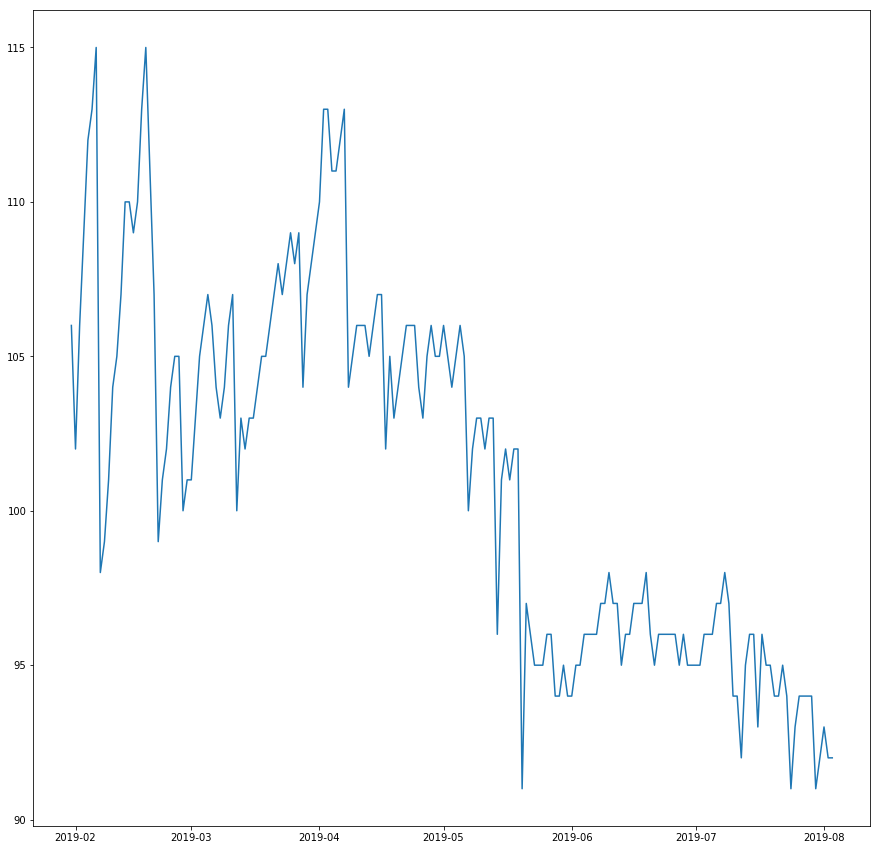

In [85]:
plt.plot(daily_inv_val_with_purchases_df.AverageDaysToSell.iloc[30:].apply(lambda x: x.days))

### Our production system also calculates the average days to sell for the prefinished flooring product group, which I am going to load up and visualize here:

In [86]:
kpis_df = pd.read_csv('kpis.csv', index_col=4)

In [87]:
kpis_df.head()

,Total Days To Sell,Prefinished Wood Days To Sell,Total,Prefinished Flooring
Date,,,,
2019-01-02,154.418191,74.261183,929733.395,361702.458
2019-01-03,23.087193,16.833838,858345.332,325736.409
2019-01-04,25.944874,21.591536,843535.320,320807.999
2019-01-07,50.803148,41.006393,846042.593,318462.714
2019-01-08,53.974813,43.337266,839168.147,313678.118


In [88]:
kpis_df.index = pd.DatetimeIndex(kpis_df.index).normalize()

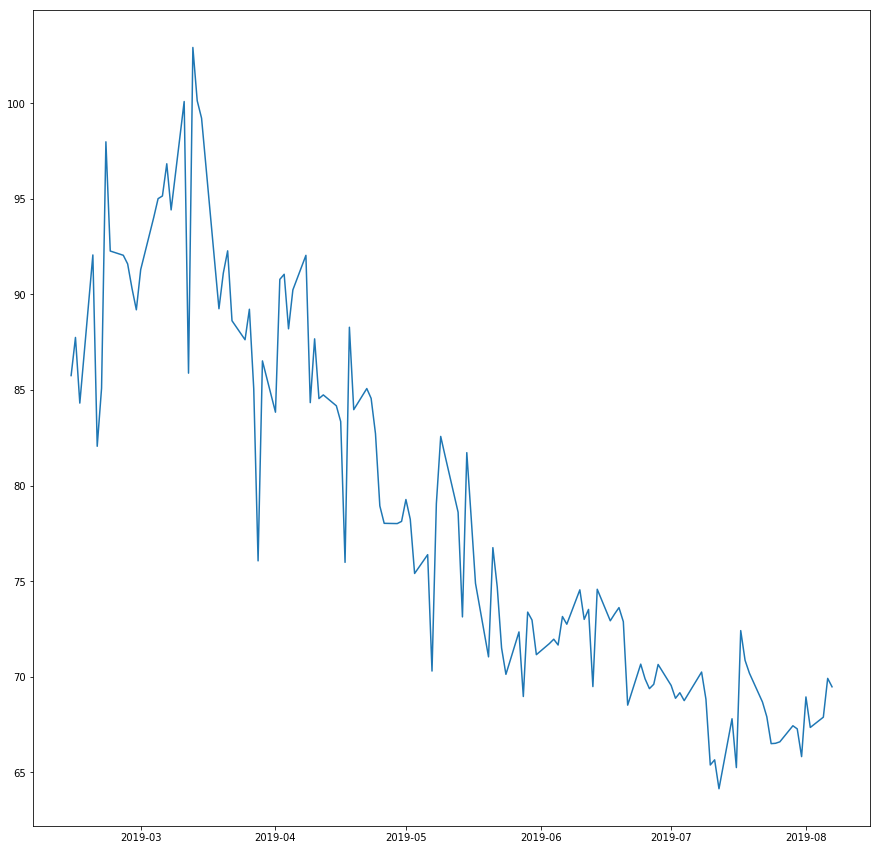

In [89]:
plt.plot(kpis_df['Prefinished Wood Days To Sell'].iloc[30:])

# Section 4, Final analysis:

We can see from these figures that we have been successful in lowering inventory value very quickly in the early stages of implementation. This has been a great help for us in two ways: First, we were able in increase our avaible cash on hand, a useful thing for any business. Second, we were able to use that availabe cash on hand to take advantage of some massive discounts our primary supplier offered us in May of this year. Had we not taken these steps to reduce our inventory value, we would have lost out on significant profit because we wouldn't be able to afforid to take more stocking product.

Another point that is worth mentioning is that while we built this system with a particular product group in mind, it is being applied to all the product groups in our inventory at the same time. We have acheived small gains in several categories that also contributed to the increase in availabe cash.  